In [1]:
# Ref:https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
from collections import Counter
import random
import ast
import re
import scipy

sys.path.append('pymodules')
# This class contains some utility functions Word2Vec, stop words etc. etc.
import pymodules.preprocessing_class as pc

# gender gueser
import gender_guesser.detector as gd

# for dictionary method synonym finder using wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
#from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
# making the plot look good ...
from adjustText import adjust_text
from sklearn.decomposition import PCA
from collections import Counter

from pprint import pprint
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout

from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

##########
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix, f1_score
# model/ensemble scorer ...
from sklearn.metrics import make_scorer
import keras
from keras.utils import to_categorical
from keras.layers import Flatten
from keras.optimizers import SGD

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout

#EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import metrics

/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package wordnet to /Users/bmukund/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/bmukund/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# for parallel run of multiple trials ...
def run_parallel(func, num_cpus=4):
    """
    A simple parallel processor
    """
    mp_pool = mp.Pool(num_cpus)
    def _run(grid_parameters):
        result = mp_pool.map(func, grid_parameters)
        return result
    return _run

# Ref: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/
def onehot_encode(data):
    """
    one hot encoding for CNN
    """
    return to_categorical(data)

# load dataset
def split_data(X, y, validation=False, shuffle=True):
    """
    load data and create validation set as well (25% of training data)
    """
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=shuffle)
    # create validation data as well
    if validation:
        trainX, validX, trainy, validy = train_test_split(trainX, trainy, test_size=0.25, random_state=42, shuffle=shuffle)
        return trainX, trainy, testX, testy, validX, validy
    else:
        return trainX, trainy, testX, testy, None, None


def plot_accuracy(model, test_str='Validation'):
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', test_str], loc='upper left')
    plt.show()

def plot_loss(model, test_str = 'Validation'):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', test_str], loc='upper left')
    plt.show()

def convert_prob_to_labels(data):
    # the outputs are probabilities, change it to classifier labels ..
    y_arg = np.argmax(data, axis=1)
    y_pred = onehot_encode(y_arg)
    return y_pred


In [3]:
def model_stats_all_labels(Y_pred, Y_actual):
    # true negatives is  C[0, 0]
    # false negatives is C[1, 0]
    # true positives is  C[1, 1]
    # false positives is C[0, 1]
    mcm = multilabel_confusion_matrix(Y_actual, Y_pred)
    tnv = mcm[:, 0, 0]
    tpv = mcm[:, 1, 1]
    fnv = mcm[:, 1, 0]
    fpv = mcm[:, 0, 1]

    accuracy = (tpv+tnv)/(tpv+tnv+fpv+fnv)
    sensitivity = tpv/(tpv+fnv)
    specificity = tnv/(tnv+fpv)
    denom = 1-specificity
    likelihood = [sensitivity[i]/denom[i] if denom[i] > 0 else np.nan for i in range(len(denom))]

    return accuracy, sensitivity, specificity, likelihood

In [4]:
def find_wordnet_synonyms(word_list, type_of_word=None):
    """ it is assumed that the word_list words are themselves synonyms and is given as a list (even if there is only one word
    return lemmatized synonyms ...
    """
    synonyms = set()
    for word_to_look in word_list:
        #print(f"looking for synonyms of word:{word_to_look}")
        for syn in wn.synsets(word_to_look, pos=type_of_word):
            for i in syn.lemmas():
                synonyms.add(i.name())
    #print(f"Synonyms:\n {synonyms}")
    return synonyms

In [5]:
# Function to get the first name so that we can guess the gender
def first_name(x):
    """
    We determine the first name from the given string. We also remove any digits from the name. 
    Further, we use space to split names
    """
    x_split = str(x).split()
    fname = x_split[0]
    # remove reference to digits. Now after removal, there could be some misclassification, but that is ok ..
    fname_p = re.sub(r'[0-9]+', "", fname)
    ret_str = fname_p.capitalize()
    return ret_str


In [6]:
filename = "data/Master-data_Q42021.xlsx"
text_data_raw = pd.read_excel(filename, sheet_name='Scrubbed_data', index_col='REVIEW_DATE')

# We don't need these columns
not_needed = ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE',
'PRODUCT_LINK', 'WEBSITE']

text_data = text_data_raw.drop(columns = not_needed, axis=1)


In [7]:
# Let us figure out the gender from the names and drop the names column
# We use gender_guesser package.
#text_data['AUTHOR'] = text_data['AUTHOR'].astype(str)
gdx = gd.Detector()
text_data['GENDER'] = text_data.AUTHOR.apply(first_name).map(lambda x: gdx.get_gender(x))

# Drop the author column now
text_data.drop(columns = ['AUTHOR'], axis=1, inplace=True)

# Check the gender counts just to see how the data looks like
text_data.GENDER.value_counts()

female           4003
male             2400
unknown          1556
mostly_female     464
mostly_male       253
andy              118
Name: GENDER, dtype: int64

In [8]:
# Consolidate the comments into one column
# Comments can occur both in title and in Comment columns. 
text_data['COMMENT'] = text_data['TITLE'].astype(str).fillna("") + " " + text_data['COMMENTS'].astype(str).fillna("")
text_data.drop(columns = ['TITLE', 'COMMENTS'], axis=1, inplace=True)

In [9]:
# clean rating
# replace N = No rating with 0. We do this because rating is assumed to be numeric, not categorical
text_data['RATING'].replace('N', '0', inplace=True)
# convert rating to integers
text_data['RATING'] = text_data['RATING'].apply(lambda x: int(x))

# attach sentiment, seems
def find_sentiment(rating):
    choices = [0, 1, 2]
    conditions = [rating < 3, rating == 3, rating > 3]
    senti = np.select(conditions, choices)
    return senti

text_data['SENTIMENT'] = text_data['RATING'].apply(find_sentiment).astype('category')

In [10]:
# display results
text_data

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT,SENTIMENT
REVIEW_DATE,,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...,2
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up,2
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...,2
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...,2
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...,2
...,...,...,...,...,...,...,...
2021-11-29,Acuvue VITA Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic...",2
2021-11-23,Shop Acuvue Vita 12 pack (1.0 Box ),5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...,2
2021-12-27,Acuvue Vita for Astigmatism Contact Lenses,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...,2


In [11]:
text_data.FINAL_PRODUCT_NAME.values[0].strip(" \t")

'Acuvue 2 Contact Lenses                                                                                     1 box - 6 pack - 3 month supply'

### Tokenization

In [12]:
## regex for tokenization
# Ref: http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py
emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""

# The components of the tokenizer:
regex_strings = (
    # Phone numbers:
    r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?
      \d{3}          # exchange
      [\-\s.]*
      \d{4}          # base
    )"""
    ,
    # Emoticons:
    emoticon_string
    ,
    # HTML tags:
    r"""<[^>]+>"""
    ,
    # Twitter username:
    r"""(?:@[\w_]+)"""
    ,
    # Twitter hashtags:
    r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
    ,
    # Remaining word types:
    r"""
    (?:[a-z][a-z'\-_]+[a-z])       # Words with apostrophes or dashes.
    |
    (?:[+\-]?\d+[,/.:-]\d+[+\-]?)  # Numbers, including fractions, decimals.
    |
    (?:[\w_]+)                     # Words without apostrophes or dashes.
    |
    (?:\.(?:\s*\.){1,})            # Ellipsis dots.
    |
    (?:\S)                         # Everything else that isn't whitespace.
    """,
    r"""
    (?x)                # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
    \w+(?:-\w+)*        # preserve expressions with internal hyphens as single tokens
    | [][.,;"'?():-_`]  # preserve punctuation as separate tokens
    """
)
word_re = re.compile(pattern=r"""(%s)""" % "|".join(regex_strings), flags=re.VERBOSE | re.I)

/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_36609/4173119622.py:65: DeprecationWarning: Flags not at the start of the expression '(\n    (?:\n      (?: ' (truncated)
  word_re = re.compile(pattern=r"""(%s)""" % "|".join(regex_strings), flags=re.VERBOSE | re.I)


In [13]:
comments_data = text_data.COMMENT
prep_comments = pc.RawDocs(comments_data,  # series of documents
                  lower_case=True,  # whether to lowercase the text in the firs cleaning step
                  stopwords='long',  # type of stopwords to initialize
                  contraction_split=True,  # wheter to split contractions or not
                  tokenization_pattern=word_re  # custom tokenization patter
                  )

In [14]:
prep_comments

In [15]:
# notice that the documents from the object are identical to the ones from the pandas series
#comments_data
i = 0
print("Document from the pandas series:\n", comments_data[i])
print("\n-------------------------\n")
print("Document from preprocessing object:\n", prep_comments.docs[i])


Document from the pandas series:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

-------------------------

Document from preprocessing object:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!


In [16]:
# lower-case text, expand contractions and initialize stopwords list
stop_lens_list = ['Lens', 'lens', 'Contact-lens', 'Contact-Lens', 'lenses', 'Lenses', 'Contact-Lenses', 'Contact-lenses', 'contact-lens', 'contact-lenses', 'acucue', 'acuvue', 'Acuvue', 'pack',
                  'box', 'Pack', 'Box', 'Moist', 'moist', 'month', 'trial']
prep_comments.basic_cleaning(custom_stopwords_list = stop_lens_list)

In [17]:
# explore an example after the basic cleaning has been applied
i = 0
print(comments_data[i])
print()
print(prep_comments.docs[i])

Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

acucue 2 contact lenses i have used these lenses for a long time and i have to say that the service from lens.com is great and the lenses work great for my needs!  i highly recommend them!


In [18]:
# now we can split the documents into tokens
prep_comments.tokenize_text()

In [19]:
i = 0
print(comments_data[i])
print()
print(prep_comments.tokens[i])

Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

['acucue', '2', 'contact', 'lenses', 'i', 'have', 'used', 'these', 'lenses', 'for', 'a', 'long', 'time', 'and', 'i', 'have', 'to', 'say', 'that', 'the', 'service', 'from', 'lens', '.', 'com', 'is', 'great', 'and', 'the', 'lenses', 'work', 'great', 'for', 'my', 'needs', '!', 'i', 'highly', 'recommend', 'them', '!']


In [20]:
punctuation = string.punctuation
punctuation = punctuation.replace("-", "") # remove the hyphen from the punctuation string
punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [21]:
prep_comments.token_clean(length=2,                 # remove tokens with less than this number of characters
                 punctuation=punctuation,           # remove custom list of punctuation characters
                 numbers = True                     # remove numbers
                 )

In [22]:
i = -1
print(comments_data[i])
print()
print(prep_comments.tokens[i])

Would buy again My order came in fast without any issues, and the candy in the box was a nice touch 😄 

['would', 'buy', 'again', 'order', 'came', 'fast', 'without', 'any', 'issues', 'and', 'the', 'candy', 'the', 'box', 'was', 'nice', 'touch']


In [23]:
# get the list of stopwords provided earlier
#print(sorted(prep_comments.stopwords))

In [24]:
# we need to specificy that we want to remove the stopwords from the "tokens"
prep_comments.stopword_remove('tokens')

In [25]:
i = -1
print(comments_data[i])
print()
print(prep_comments.tokens[i])

Would buy again My order came in fast without any issues, and the candy in the box was a nice touch 😄 

['buy', 'order', 'came', 'fast', 'without', 'issues', 'candy', 'nice', 'touch']


In [26]:
# apply lemmatization to all documents (takes a very long time so we will avoid it for now)
prep_comments.lemmatize()

In [27]:
# compare all versions of the same raw sentences
i = -1
print(comments_data[i])
print()
print(prep_comments.tokens[i])
print()
print(prep_comments.lemmas[i])

Would buy again My order came in fast without any issues, and the candy in the box was a nice touch 😄 

['buy', 'order', 'came', 'fast', 'without', 'issues', 'candy', 'nice', 'touch']

['buy', 'order', 'come', 'fast', 'without', 'issue', 'candy', 'nice', 'touch']


In [28]:
# Create Dictionary
id2word = corpora.Dictionary(prep_comments.tokens)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in prep_comments.tokens]

In [29]:
text_data['TOKENS'] = prep_comments.tokens

In [30]:
text_data

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT,SENTIMENT,TOKENS
REVIEW_DATE,,,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...,2,"[contact, used, time, service, com, great, wor..."
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up,2,"[clear, vision, tends, cloud]"
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...,2,"[comfort, hard, handle, flimsy, comfortable, e..."
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...,2,"[easy, use, using, product, years, reliable]"
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...,2,"[excellent, excellent, got, promised, discount..."
...,...,...,...,...,...,...,...,...
2021-11-29,Acuvue VITA Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic...",2,"[truly, best, price, fast, shipping, quick, ve..."
2021-11-23,Shop Acuvue Vita 12 pack (1.0 Box ),5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...,2,"[comfortable, vita, comfortable, wear, fact, c..."
2021-12-27,Acuvue Vita for Astigmatism Contact Lenses,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...,2,"[comfortable, convenient, comfortable, conveni..."


In [31]:
dfXY = text_data[['TOKENS', 'SENTIMENT']]
#tks = dfXY['TOKENS'].apply(lambda x: ",".join(x))
#tks

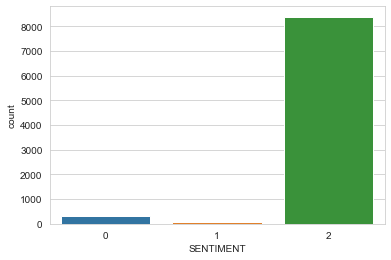

In [32]:
sns.countplot(dfXY.SENTIMENT)
plt.show()

### Highly imbalanced data
* Because of highly imbalanced data, we need to "balance" by using class weights while fitting any model

### take tokenized sentences and make it all integers using keras tokenizer on already tokenized data

In [33]:
# because embedding is independent of tokenization, we integerize our token based on keras tokenizer
num_expected_unique_words = 10000
keras_tokenizer = Tokenizer(num_expected_unique_words, split=",")
keras_tokenizer.fit_on_texts(dfXY['TOKENS'])

In [34]:
validation_reqd = True
X = dfXY.TOKENS
y = dfXY.SENTIMENT
df_trainX, df_trainy, df_testX, df_testy, df_validX, df_validy = split_data(X, y, validation_reqd)

In [35]:
MAX_SEQ_LEN = 300
X_train=keras_tokenizer.texts_to_sequences(df_trainX) # this converts texts into some numeric sequences
X_train_pad=pad_sequences(X_train,maxlen=MAX_SEQ_LEN,padding='post') # this makes the length of all numeric sequences equal

X_test = keras_tokenizer.texts_to_sequences(df_testX)
X_test_pad = pad_sequences(X_test, maxlen = MAX_SEQ_LEN, padding = 'post')

if validation_reqd:
    X_val = keras_tokenizer.texts_to_sequences(df_validX)
    X_val_pad = pad_sequences(X_val, maxlen = MAX_SEQ_LEN, padding = 'post')
else:
    X_val = None
    X_val_pad = None

In [36]:
y_train = to_categorical(df_trainy.values,num_classes=3)
y_test = to_categorical(df_testy.values, num_classes=3)
if validation_reqd:
    y_val = to_categorical(df_validy.values, num_classes=3)
else:
    y_val = None

### Compute class weights based on training data to balance the dataset

In [37]:
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
sentiment_class_weights = dict(enumerate(class_weights))

{0: 8.454700854700855, 1: 42.27350427350427, 2: 0.34988681380871534}


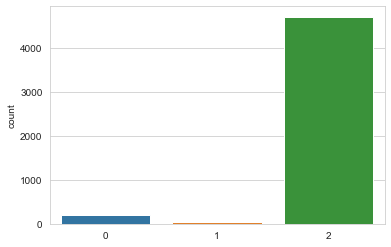

[ 195   39 4712]


TypeError: cannot unpack non-iterable int object

In [58]:
### Test if balancing has indeed taken place ...
print(sentiment_class_weights)
sns.countplot(y_integers)
plt.show()
print(np.bincount(y_integers))
balance_wts = np.array([val for k, val in sentiment_class_weights.items()])
bal = np.round(np.bincount(y_integers) * balance_wts)
sns.countplot(bal)
plt.show()

In [39]:
# train Gensim's Word2Vec model
gensim_model = Word2Vec(sentences=prep_comments.tokens,      # corpus
                        vector_size=100,            # embedding dimension
                        window=4,                   # words before and after to take into consideration
                        sg=1,                       # use skip-gram
                        negative=5,                 # number of negative examples for each positive one
                        alpha=0.025,                # initial learning rate
                        min_alpha=0.0001,           # minimum learning rate
                        epochs=10,                   # number of passes through the data
                        min_count=1,                # words that appear less than this are removed
                        workers=4,                  # we use 1 to ensure replicability
                        seed=92                     # for replicability
                        )

In [40]:
# extract the word embeddings from the model
word_vectors = gensim_model.wv
word_vectors.vectors.shape  # vocab_size x embeddings dimension

(3866, 100)

In [41]:
word_vectors_weights = gensim_model.wv.vectors
vocab_size, embedding_size = word_vectors_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 3866 - Embedding Dim: 100


In [42]:
# Some validation on the quality of the Word2Vec model
print(gensim_model.wv.most_similar('product', topn=3))
print(gensim_model.wv.most_similar('price', topn=3))
print(gensim_model.wv.most_similar('service', topn=3))
print(gensim_model.wv.most_similar('quality', topn=3))
print(gensim_model.wv.most_similar(positive=['comfort', 'fit'], negative=['dry'], topn=3))

def word2token(word):
    try:
        return gensim_model.wv.key_to_index[word]
    except KeyError:
        return 0

def token2word(token):
    return gensim_model.wv.index_to_key[token]

[('complaints', 0.8702638745307922), ('products', 0.8641768097877502), ('usual', 0.8614597916603088)]
[('reasonable', 0.8841522932052612), ('competition', 0.8838729858398438), ('inexpensive', 0.8740906119346619)]
[('pricing', 0.900398850440979), ('services', 0.8933537602424622), ('prompt', 0.8931659460067749)]
[('inexpensive', 0.9042515754699707), ('organization', 0.8804221749305725), ('value', 0.8797671794891357)]
[('clarity', 0.7733932137489319), ('perfectly', 0.6968207359313965), ('durability', 0.6820732355117798)]


In [43]:
gensim_weight_matrix = np.zeros((num_expected_unique_words ,embedding_size))
gensim_weight_matrix.shape

(10000, 100)

In [44]:
word_vectors[word_vectors.key_to_index['dry']]

array([-3.38037997e-01, -1.34983137e-01,  7.72877410e-02,  6.12533614e-02,
       -9.86203104e-02, -1.55446500e-01, -5.29047191e-01, -1.05186692e-02,
       -4.91448939e-02,  3.55687320e-01,  5.32495141e-01, -2.35072628e-01,
       -1.51466101e-01,  8.12988281e-02,  7.76161477e-02,  5.43651124e-03,
       -1.30008534e-01, -3.93275082e-01,  2.50357419e-01, -4.10402358e-01,
        1.10914856e-01,  1.27900600e-01,  4.08221692e-01,  5.34513593e-01,
       -1.65222764e-01,  1.73050128e-02,  1.00055724e-01, -3.32566619e-01,
       -5.58326006e-01,  5.15291989e-02,  4.51415062e-01,  2.05058828e-02,
       -4.96495187e-01,  1.18566528e-02,  5.92020154e-01,  7.55863916e-03,
        3.01478595e-01, -1.09993294e-01, -1.52051136e-01, -3.41683477e-01,
        1.49139196e-01,  9.60008428e-02, -2.51444787e-01, -5.61590716e-02,
       -2.43236020e-01,  3.61189842e-01,  1.33766696e-01, -7.56917670e-02,
        1.34895861e-01,  8.65559578e-01, -4.39783819e-02,  7.66111195e-01,
       -5.25952578e-02, -

### map the index of the word (obtained by keras_tokenizer, which assigned interger values to words) to its weight matrix obtained from wrod embedding

In [45]:
for word, index in keras_tokenizer.word_index.items():
    if index < num_expected_unique_words: # why ? since index starts with zero
        try:
            word_index_in_embedding = word_vectors.key_to_index[word]
        except KeyError:
            gensim_weight_matrix[index] = np.zeros(embedding_size)
        else:
            gensim_weight_matrix[index] = word_vectors[word_index_in_embedding]

In [46]:
gensim_weight_matrix.shape

(10000, 100)

### RNN model

In [47]:
num_sentiments  = 3
print(f"input length:{X_train_pad.shape[1]}")

model = Sequential()
model.add(Embedding(input_dim = num_expected_unique_words,
                    output_dim = embedding_size,
                    input_length= X_train_pad.shape[1],
                    weights = [gensim_weight_matrix],
                    trainable = False))

model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(num_sentiments, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

input length:300


2022-06-27 12:24:24.647006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
#EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./sentiment_RNN_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [50]:
if validation_reqd:
    history_embedding = model.fit(X_train_pad, y_train,
                                  epochs = 2,
                                  batch_size = 120,
                                  validation_data=(X_val_pad, y_val),
                                  verbose = 1,
                                  callbacks= [es, mc],
                                  class_weight = sentiment_class_weights,
                                  workers=4,
                                  use_multiprocessing=True)
else:
    history_embedding = model.fit(X_train_pad, y_train,
                                  epochs = 2,
                                  batch_size = 120,
                                  verbose = 1,
                                  callbacks= [es, mc],
                                  class_weight = sentiment_class_weights,
                                  workers=4,
                                  use_multiprocessing=True)


_, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Accuracy of model is: {accuracy}')

Epoch 1/2
42/42 [==============================] - ETA: 0s - loss: 1.0540 - accuracy: 0.6927
Epoch 1: val_accuracy improved from -inf to 0.79321, saving model to ./sentiment_RNN_model.h5
42/42 [==============================] - 148s 3s/step - loss: 1.0540 - accuracy: 0.6927 - val_loss: 0.8651 - val_accuracy: 0.7932
Epoch 2/2
42/42 [==============================] - ETA: 0s - loss: 0.9845 - accuracy: 0.7982
Epoch 2: val_accuracy did not improve from 0.79321
69/69 [==============================] - 23s 334ms/step - loss: 0.9688 - accuracy: 0.7676
Accuracy of model is: 0.767621636390686


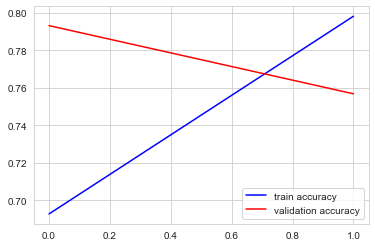

In [51]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [52]:
y_pred_raw =model.predict(X_test_pad, workers=4, use_multiprocessing=True)

69/69 [==============================] - 25s 333ms/step


In [53]:
y_pred =   np.argmax(y_pred_raw, axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_pred, y_true))
#
#y_pred = convert_prob_to_labels(y_pred_raw)
#print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.20      0.08      0.11       213
           1       0.71      0.04      0.08       296
           2       0.79      0.98      0.88      1690

    accuracy                           0.77      2199
   macro avg       0.57      0.37      0.36      2199
weighted avg       0.72      0.77      0.69      2199



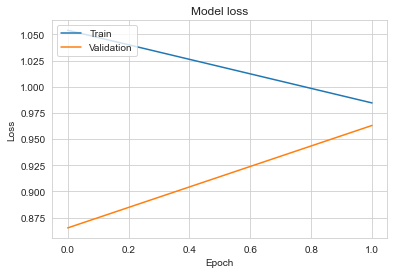

In [54]:
plot_loss(history_embedding)

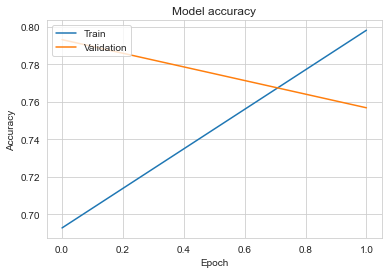

In [55]:
plot_accuracy(history_embedding)

In [56]:
# use a PCA decomposition to visualize the embeddings in 2D
def pca_scatterplot(model, words):
    pca = PCA(n_components=2, random_state=92)
    word_vectors = np.array([model[w] for w in words])
    low_dim_emb = pca.fit_transform(word_vectors)
    plt.figure(figsize=(21,10))
    plt.scatter(low_dim_emb[:,0], low_dim_emb[:,1], edgecolors='blue', c='blue')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # get the text of the plotted words
    texts = []
    for word, (x,y) in zip(words, low_dim_emb):
        texts.append(plt.text(x+0.01, y+0.01, word, rotation=0))

    # adjust the position of the labels so that they dont overlap
    adjust_text(texts)
    # show plot
    plt.show()

['dryer', 'usual', 'seems', 'shelf', 'awhile', 'disappointed']


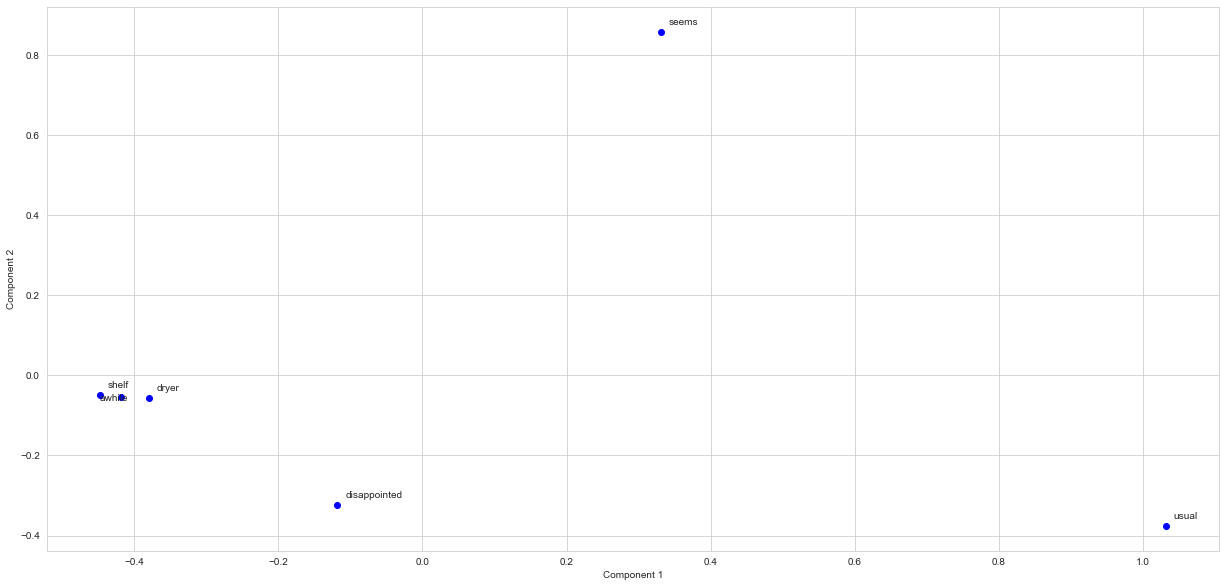

In [57]:
# define the tokens to use in the plot
tokens_of_interest = ['dryer', 'usual', 'seems', 'shelf', 'awhile', 'disappointed']
print(tokens_of_interest)
# expand the list of tokens with all the tokens from the replacement dictionary
#tokens_of_interest = set(tokens_of_interest) + list(replacing_dict.values()) )

# plot
pca_scatterplot(word_vectors, tokens_of_interest)